In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import numpy as np
import uproot
import hist

NanoAODSchema.warn_missing_crossrefs = False
hep.style.use('CMS')

In [79]:
def ChargeOrdering(LEPTON):
    ''' Sort charge from each event negative first then postive. '''
    index = ak.argsort(LEPTON.charge)
    return LEPTON[index]

def LeptonSelection(DATA, PT, ETA, FLAVOR):
    ''' Event selection: electron antielectron pair, electron.pt > PT, electron.eta > ETA,
    ensures charge conservation and allows for 2 or 4 lepton pairs. '''
    if FLAVOR == 'Electron': x = DATA.Electron
    elif FLAVOR == 'Muon': x = DATA.Muon
    mask_pT_eta = ak.all(x.pt > PT, axis=-1) & ak.all(x.eta > ETA, axis=-1)
    x = x[mask_pT_eta]
    mask_charge = ak.sum(x.charge, axis=-1) == 0
    mask_2e = ak.num(x, axis=-1) == 2
    mask_4e = ak.num(x, axis=-1) == 4
    mask = mask_charge & (mask_2e | mask_4e)
    return x[mask]

def TwoLeptonIM(LEPTON):
    twoLepVec = LEPTON[:,0].add(LEPTON[:,1])
    return twoLepVec.mass

def FourLeptonIM(LEPTON):
    MASS = []
    for i in range(2):
        for j in range(2):
            MASS.append((LEPTON[:,i].add(LEPTON[:,j+2])).mass)
    return MASS

def InvariantMassHist(LEPTON, BINS):
    h = hist.Hist(hist.axis.Regular(BINS, 0, 180, name='Invariant Mass[GeV/C^2]'))
    mask_2l = ak.num(LEPTON, axis=-1) == 2
    mask_4l = ak.num(LEPTON, axis=-1) == 4
    lep2 = LEPTON[mask_2l]
    lep4 = LEPTON[mask_4l]
    h.fill(TwoLeptonIM(lep2))
    for i in range(4):
        h.fill(FourLeptonIM(lep4)[i])
    return h 

def addStats(H):
    stats = (np.atleast_1d(H.profile(axis=0).view())[0])
    count , mean , sumDeltaSquared = int(stats['count']), stats['value'], stats['_sum_of_deltas_squared']
    std = np.sqrt(sumDeltaSquared/count)
    statbox = f'{"Entries":<{10}}{count:d}' + '\n' + f'{"Mean":<{10}}{mean:.3f}' + '\n' + f'{"Std Dev":<{10}}{std:.3f}'
    return statbox

def cmsPlot(H):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_ylabel('Events', fontsize=24)
    ax.set_xlabel('$[GeV/C^{2}$]', fontsize=15)
    hep.histplot(H,label='$M_{ee}$',histtype='fill')
    # hep.cms.label(rlabel="pT > 20 GeV/C")
    plt.tight_layout()
    stats = addStats(h1)
    plt.text(0.77, 0.90, stats, ha='left', va='top', transform=ax.transAxes, fontsize = 15, bbox = dict(alpha = 0.15))
    plt.savefig('InvariantMassPlot.jpg')
    plt.show()

In [3]:
fname = 'root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/ForHiggsTo4Leptons/Run2012B_DoubleElectron.root'

In [104]:
events = NanoEventsFactory.from_root(
    fname, schemaclass=NanoAODSchema.v6, entry_stop=5000000
).events()

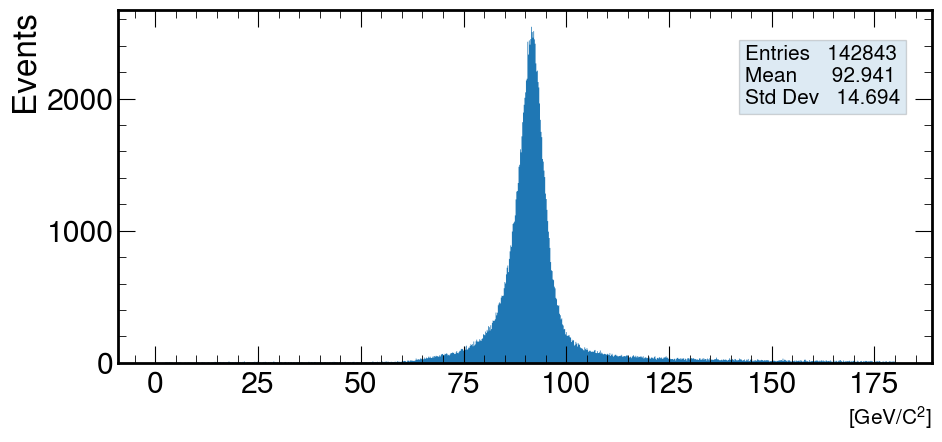

In [109]:
selectedLeptons = ChargeOrdering(LeptonSelection(events, 30, 0, 'Electron'))
h1 = InvariantMassHist(selectedLeptons,1000)
cmsPlot(h1)

In [106]:
def pdf(x, a=1 / np.sqrt(2 * np.pi), x0=92.941, sigma=14.694, offset=0):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) + offset

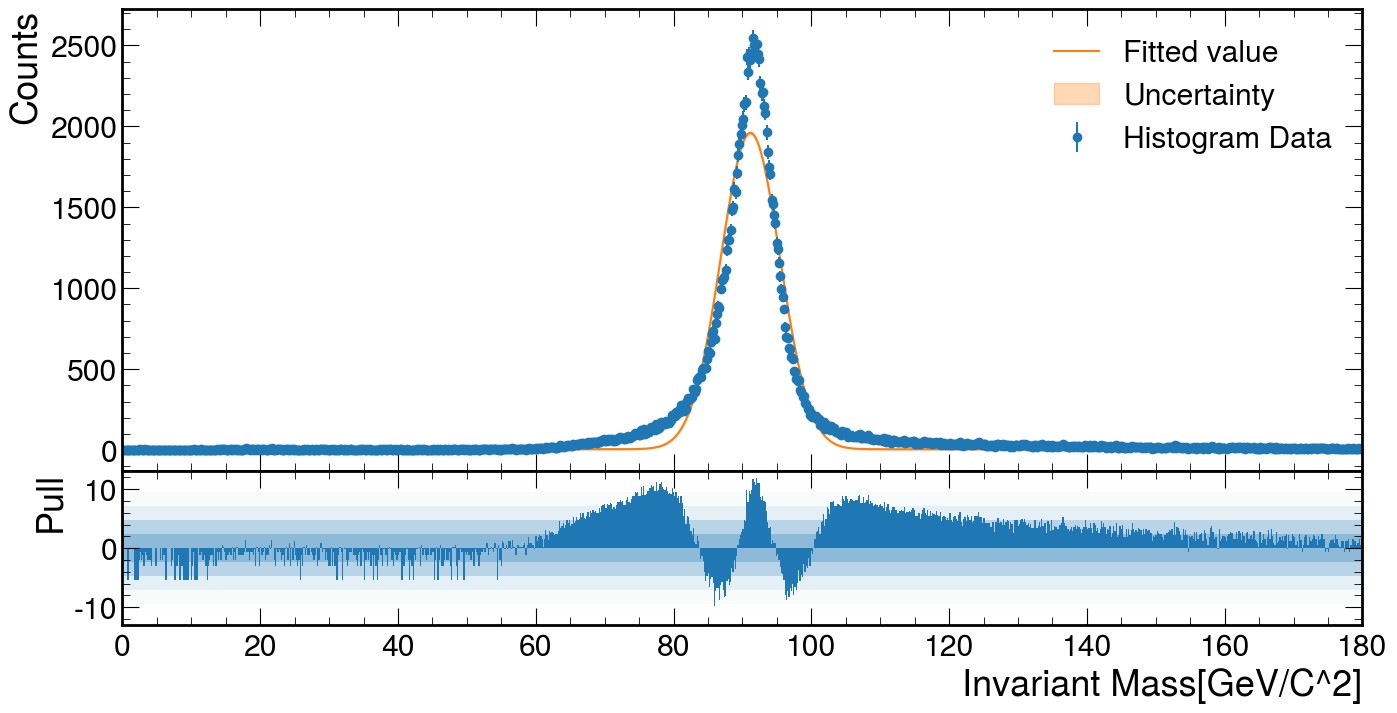

In [108]:
fig = plt.figure(figsize=(16, 8))
main_ax_artists, sublot_ax_arists = h1.plot_pull(pdf)
plt.savefig('fit.jpg')